In [1]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-06-19 06:47:42--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.197.128, 2607:f8b0:4001:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   125MB/s    in 0.7s    

2020-06-19 06:47:42 (125 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [2]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(input_shape = (150,150,3),
                                include_top = False,
                                weights = None)
pre_trained_model.load_weights(local_weights_file)
for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [3]:
last_layer = pre_trained_model.get_layer('mixed7')
print(last_layer.output_shape)
last_output = last_layer.output

(None, 7, 7, 768)


In [4]:
from tensorflow.keras.optimizers import RMSprop
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)
model = Model(pre_trained_model.input, x)
model.compile(optimizer = RMSprop(lr=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [5]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

--2020-06-19 06:48:06--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.197.128, 2607:f8b0:4001:c19::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   157MB/s    in 0.4s    

2020-06-19 06:48:07 (157 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs = 20,
    verbose = 2
)

Epoch 1/20
100/100 - 24s - loss: 0.3417 - accuracy: 0.8665 - val_loss: 0.0930 - val_accuracy: 0.9670
Epoch 2/20
100/100 - 22s - loss: 0.2118 - accuracy: 0.9160 - val_loss: 0.1120 - val_accuracy: 0.9640
Epoch 3/20
100/100 - 22s - loss: 0.2014 - accuracy: 0.9260 - val_loss: 0.1334 - val_accuracy: 0.9610
Epoch 4/20
100/100 - 22s - loss: 0.2232 - accuracy: 0.9175 - val_loss: 0.1282 - val_accuracy: 0.9540
Epoch 5/20
100/100 - 25s - loss: 0.1720 - accuracy: 0.9380 - val_loss: 0.1086 - val_accuracy: 0.9650
Epoch 6/20
100/100 - 22s - loss: 0.2046 - accuracy: 0.9360 - val_loss: 0.1045 - val_accuracy: 0.9690
Epoch 7/20
100/100 - 22s - loss: 0.1829 - accuracy: 0.9380 - val_loss: 0.1556 - val_accuracy: 0.9550
Epoch 8/20
100/100 - 22s - loss: 0.1802 - accuracy: 0.9390 - val_loss: 0.1374 - val_accuracy: 0.9570
Epoch 9/20
100/100 - 22s - loss: 0.1533 - accuracy: 0.9450 - val_loss: 0.1271 - val_accuracy: 0.9700
Epoch 10/20
100/100 - 22s - loss: 0.1685 - accuracy: 0.9480 - val_loss: 0.1474 - val_accura

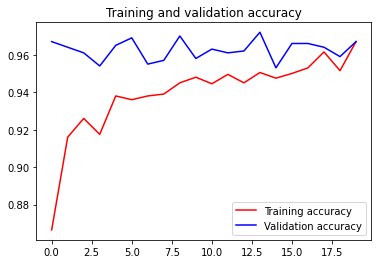

<Figure size 432x288 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()